In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import os, pathlib
import sklearn, PIL
# 🔄 Cleanup cell — run this BEFORE rebuilding pipelines/model
import gc, tensorflow as tf


In [ ]:
#!pip install -U "tensorflow==2.19.*" "numpy>=2.1,<2.3" "ml-dtypes>=0.5.0" \
#  "protobuf>=5.26.1,<6.0" scikit-learn matplotlib pillow


In [ ]:
#!pip uninstall -y tf-keras keras tensorflow-text tensorflow-decision-forests ydf \
#  opencv-python opencv-python-headless opencv-contrib-python jax jaxlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#check
from PIL import Image
sizes = {}
modes  = {}

p = "/content/drive/MyDrive/Hens data science project/Bone_Fracture_Binary_Classification/train/fractured/00004541.png"

with Image.open(p) as im:
  sizes[im.size] = sizes.get(im.size, 0) + 1   # im.size = (width, height)
  modes[im.mode] = modes.get(im.mode, 0) + 1   # e.g., 'RGB', 'L' (grayscale), 'P' (GIF palette), 'RGBA'

print(sizes)
print(modes)

{(1517, 2021): 1}
{'L': 1}


In [ ]:
# ---- CONFIG ----

DATASET_DIR = "/content/drive/MyDrive/Hens data science project/Bone_Fracture_Binary_Classification"
IMG_SIZE = (512, 512)
BATCH_SIZE = 4



In [ ]:
tf.keras.backend.clear_session()  # frees TF/graph/GPU state
gc.collect()                      # asks Python to free RAM

0

In [ ]:
# ---- BUILD DATAFRAME ----
rows = []

for category in ["train", "val", "test"]:
    category_path = os.path.join(DATASET_DIR, category)
    if not os.path.exists(category_path):
        continue

    # Go over label folders (fractured / not fractured)
    for label in os.listdir(category_path):
        label_path = os.path.join(category_path, label)
        if not os.path.isdir(label_path):
            continue

        # Count how many images are in this label
        count = sum(
            1 for f in os.listdir(label_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        )

        # Add to rows
        rows.append({"category": category, "label": label, "count": count})

# נבנה DataFrame
df = pd.DataFrame(rows, columns=["category", "label", "count"])
print(df)

  category          label  count
0    train      fractured   4606
1    train  not fractured   4659
2      val  not fractured    492
3      val      fractured    337
4     test  not fractured    268
5     test      fractured    238


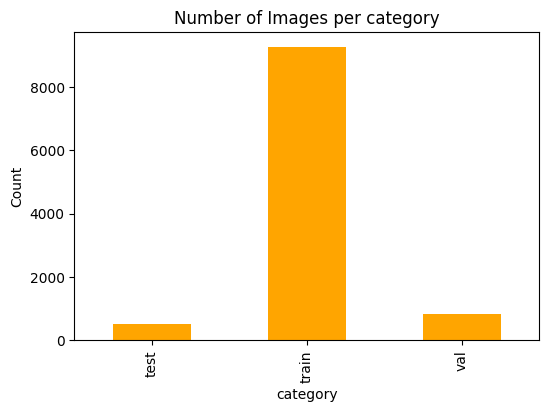

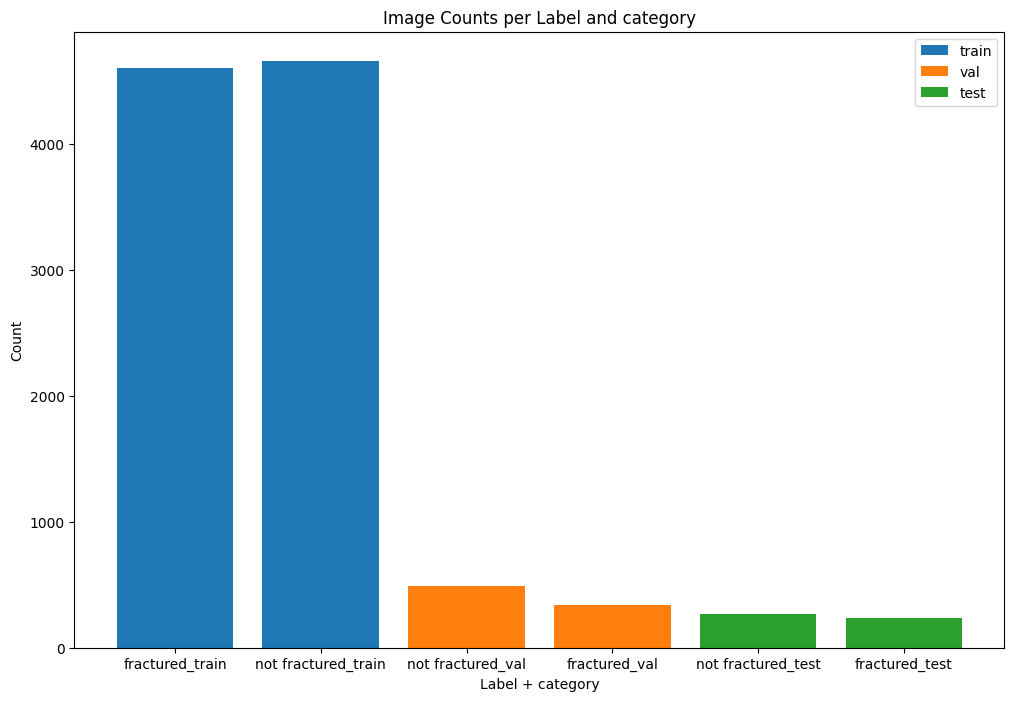

In [ ]:
# ---- Histogram: Distribution by category ----
plt.figure(figsize=(6,4))
df.groupby("category")["count"].sum().plot(kind="bar", color="orange")
plt.title("Number of Images per category")
plt.xlabel("category")
plt.ylabel("Count")
plt.show()

# ---- Grouped Bar Chart: Label per category ----
plt.figure(figsize=(12,8))
for category in df["category"].unique():
    subset = df[df["category"] == category]
    plt.bar(subset["label"] + "_" + category, subset["count"], label=category)

plt.title("Image Counts per Label and category")
plt.xlabel("Label + category")
plt.ylabel("Count")
plt.legend()
plt.show()

In [ ]:
# Convert 1‑channel → 3‑channel (ImageNet backbones expect RGB)
def to_rgb(x, y):
    x = tf.image.grayscale_to_rgb(x)  # [H,W,1] -> [H,W,3]
    return x, y

def build_ds(split, shuffle=False, disk_cache_path=None):
    ds = tf.keras.utils.image_dataset_from_directory(
        os.path.join(DATASET_DIR, split),
        labels="inferred", label_mode="binary",
        color_mode="grayscale",
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    ).ignore_errors()

    if disk_cache_path is not None:
        ds = ds.cache(disk_cache_path)  # optional, to disk (e.g., "/content/cache_train")

    if shuffle:
        ds = ds.shuffle(buffer_size=BATCH_SIZE*16, seed=42, reshuffle_each_iteration=True)

    ds = ds.map(to_rgb, num_parallel_calls=1)  # keep parallelism low to save RAM
    ds = ds.prefetch(1)                        # tiny rolling buffer, not full cache
    return ds

train_ds = build_ds("train", shuffle=True)                 # no cache
val_ds   = build_ds("val",   shuffle=False)                # no cache
test_ds  = build_ds("test",  shuffle=False)                # no cache




# # --- Load datasets (expects subfolders fractured / not fractured under each split) ---
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     os.path.join(DATASET_DIR, "train"),
#     labels="inferred",
#     label_mode="binary",
#     color_mode="grayscale",
#     image_size=IMG_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=True
# ).apply(tf.data.experimental.ignore_errors())



Found 9265 files belonging to 2 classes.
Found 829 files belonging to 2 classes.
Found 506 files belonging to 2 classes.


In [ ]:
# Modest augmentations (be conservative for medical images)
# data_augmentation = keras.Sequential([
#     layers.RandomRotation(0.02),
#     layers.RandomZoom(0.05),
#     layers.RandomTranslation(0.05, 0.05),
#     # layers.RandomFlip("horizontal"),  # ⚙️ TODO: enable only if a left/right flip doesn’t break semantics in your data
# ])

In [ ]:
from tensorflow.keras.applications import densenet
base = densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # phase 1: frozen

inputs = keras.Input(shape=IMG_SIZE + (3,))
x = densenet.preprocess_input(inputs)  # match ImageNet preprocessing
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # ⚙️ TODO: tune dropout (0.2–0.5)
outputs = layers.Dense(1, activation="sigmoid")(x)  # binary

model = keras.Model(inputs, outputs)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ],
)

cb = [
    keras.callbacks.ModelCheckpoint("best_freeze.keras", save_best_only=True, monitor="val_auc", mode="max"),
    keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_auc", mode="max")
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,   # ⚙️ TODO: tune
    callbacks=cb
)

Epoch 1/3
   2308/Unknown 1835s 700ms/step - accuracy: 0.6859 - auc: 0.7542 - loss: 0.5777 - precision: 0.6747 - recall: 0.7065

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2308/2308 ━━━━━━━━━━━━━━━━━━━━ 2148s 836ms/step - accuracy: 0.6859 - auc: 0.7543 - loss: 0.5776 - precision: 0.6747 - recall: 0.7066 - val_accuracy: 0.8647 - val_auc: 0.8998 - val_loss: 0.4012 - val_precision: 0.8645 - val_recall: 0.9118
Epoch 2/3
2308/2308 ━━━━━━━━━━━━━━━━━━━━ 147s 63ms/step - accuracy: 0.8395 - auc: 0.9088 - loss: 0.3948 - precision: 0.8245 - recall: 0.8602 - val_accuracy: 0.8782 - val_auc: 0.9225 - val_loss: 0.3536 - val_precision: 0.8855 - val_recall: 0.9097
Epoch 3/3
2308/2308 ━━━━━━━━━━━━━━━━━━━━ 261s 89ms/step - accuracy: 0.8586 - auc: 0.9311 - loss: 0.3473 - precision: 0.8462 - recall: 0.8772 - val_accuracy: 0.8918 - val_auc: 0.9362 - val_loss: 0.3278 - val_precision: 0.9128 - val_recall: 0.9013


In [ ]:
import os
print(os.getcwd())   # shows current folder

/content


In [ ]:
#saves the training weights
import json
save_path = "/content/drive/MyDrive/Hens data science project/Bone_Fracture_Binary_Classification/"

with open(save_path + "training_history.json", "w") as f:
    json.dump(history1.history, f)

In [ ]:
# uploade training weights
save_path = "/content/drive/MyDrive/Hens data science project/Bone_Fracture_Binary_Classification/"

with open(save_path + "training_history.json", "r") as f:
    history = json.load(f)

In [ ]:
# הפעלת המודל על הסט מבחן
y_pred_probs = model.predict(test_ds)



124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
print(y_pred_probs[len(y_pred_probs)-20:])
y_pred = (y_pred_probs > 0.5).astype(int) # 0 or 1
print(y_pred[len(y_pred)-20:])


[[0.94705844]
 [0.8938902 ]
 [0.1338134 ]
 [0.64418954]
 [0.06521703]
 [0.32933643]
 [0.47969627]
 [0.6479848 ]
 [0.9437885 ]
 [0.8113199 ]
 [0.78545666]
 [0.7700633 ]
 [0.49342835]
 [0.56543654]
 [0.09787239]
 [0.8776052 ]
 [0.8776052 ]
 [0.09787239]
 [0.8594932 ]
 [0.01718371]]
[[1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]]


In [ ]:
#y_pred = np.argmax(y_pred_probs, axis=1)

# comparison to the real labels

y_true = tf.concat([y for x, y in test_ds], axis=0).numpy()
print(y_true[len(y_pred_probs)-20:])



[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.86      0.93      0.89       238
    Fracture       0.93      0.86      0.89       256

    accuracy                           0.89       494
   macro avg       0.89      0.89      0.89       494
weighted avg       0.90      0.89      0.89       494



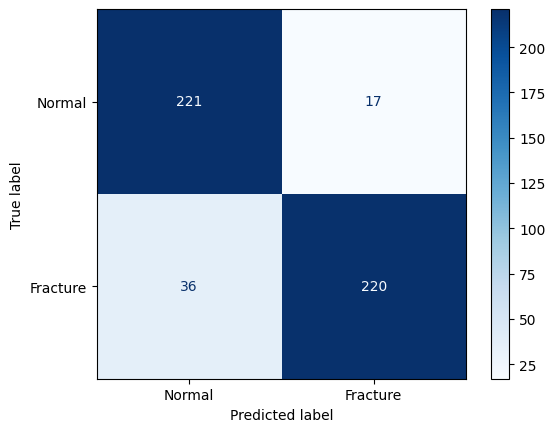

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred, labels=None):
    # Print all key metrics in one line per class + averages
    print("=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    # Show confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels if labels else None)
    disp.plot(cmap="Blues", values_format="d")
    plt.show()

# הערכה
evaluate_model(y_true, y_pred, labels=["Normal", "Fracture"])
